In [1]:
# Based on https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [2]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("../Downloads/trainingandtestdata/training.1600000.processed.noemoticon.csv", header=None, names=cols, encoding='latin-1')
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df['pre_clean_len'] = [len(t) for t in df.text]
testing = df.text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner_updated(t))
test_result

['awww that bummer you shoulda got david carr of third day to do it',
 'is upset that he can not update his facebook by texting it and might cry as result school today also blah',
 'dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it not behaving at all mad why am here because can not see you all over there',
 'not the whole crew',
 'need hug',
 'hey long time no see yes rains bit only bit lol fine thanks how you',
 'nope they did not have it',
 'que me muera',
 'spring break in plain city it snowing',
 'just re pierced my ears',
 'could not bear to watch it and thought the ua loss was embarrassing',
 'it it counts idk why did either you never talk to me anymore',
 'would ve been the first but did not have gun not really though zac snyder just doucheclown',
 'wish got to watch it with you miss you and how was the premiere',
 'hollis death scene will hurt me severely to watch on film wry is directors cut no

In [3]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

/usr/local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [4]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [5]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
398,NaN,0
430,NaN,0
1011,NaN,0


In [6]:
np.sum(my_df.isnull().any(axis=1))

3247

In [7]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

In [8]:
df = pd.read_csv("../Downloads/trainingandtestdata/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm
1011,0,1468061127,Mon Apr 06 23:30:23 PDT 2009,NO_QUERY,gabysslave,@citizensheep


In [9]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596753 entries, 0 to 1596752
Data columns (total 2 columns):
text      1596753 non-null object
target    1596753 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


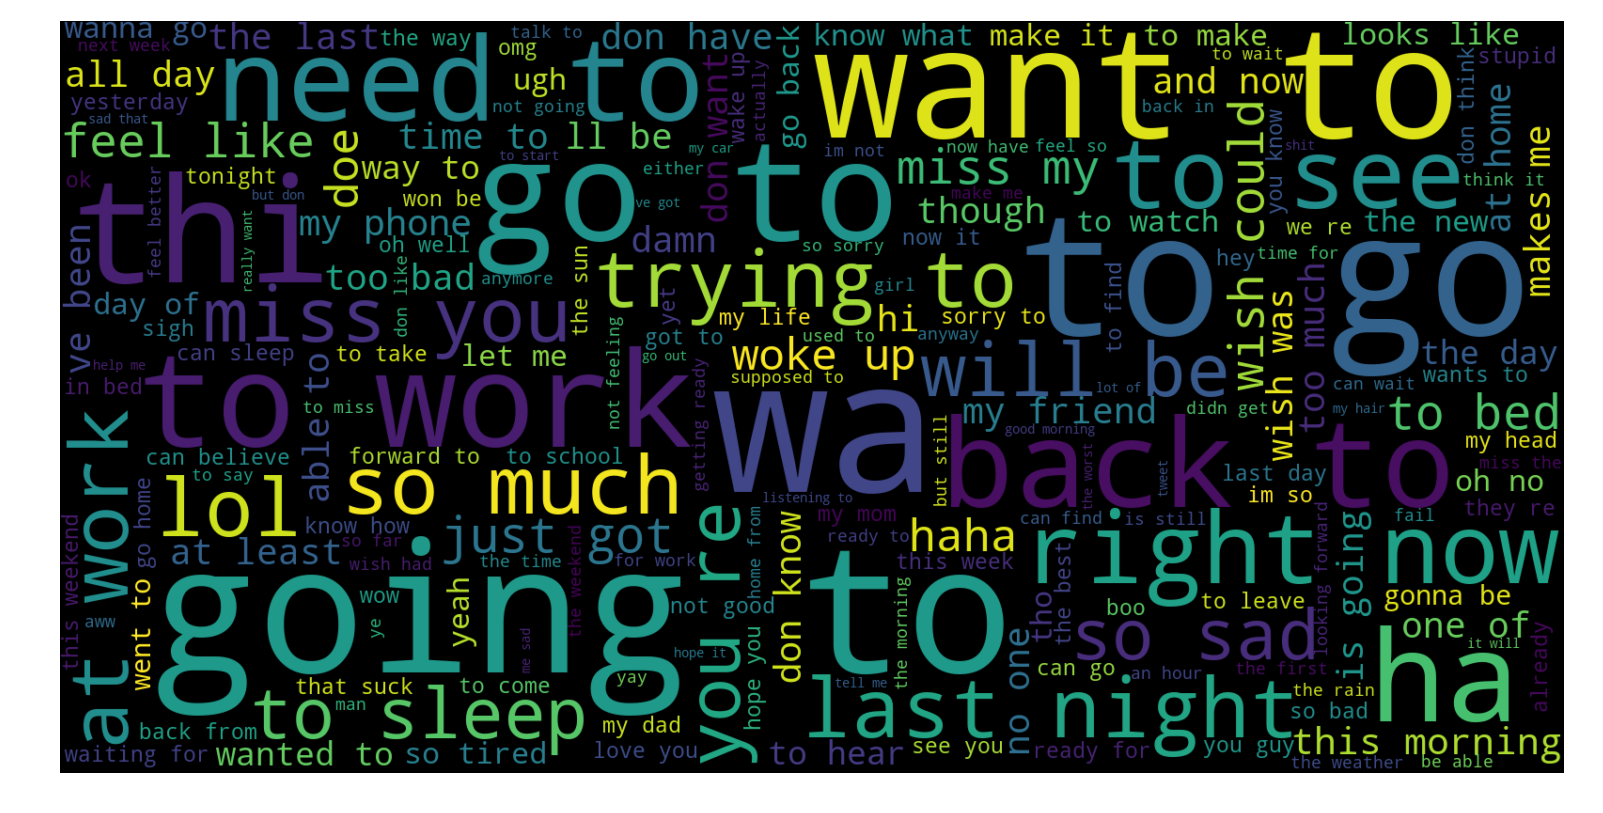

In [10]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print(t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe i love you too am here i miss you
damn the grind is inspirational and saddening at the same time don t want you to stop cuz i like what u do much love
i m missing you babe but as long as your alive i m happy yawwwnn i m tired my love imma try to sleep hopefully you had a headstart
love the french i tell people here in the south i m qtr french and they snarl at me french are beautiful people


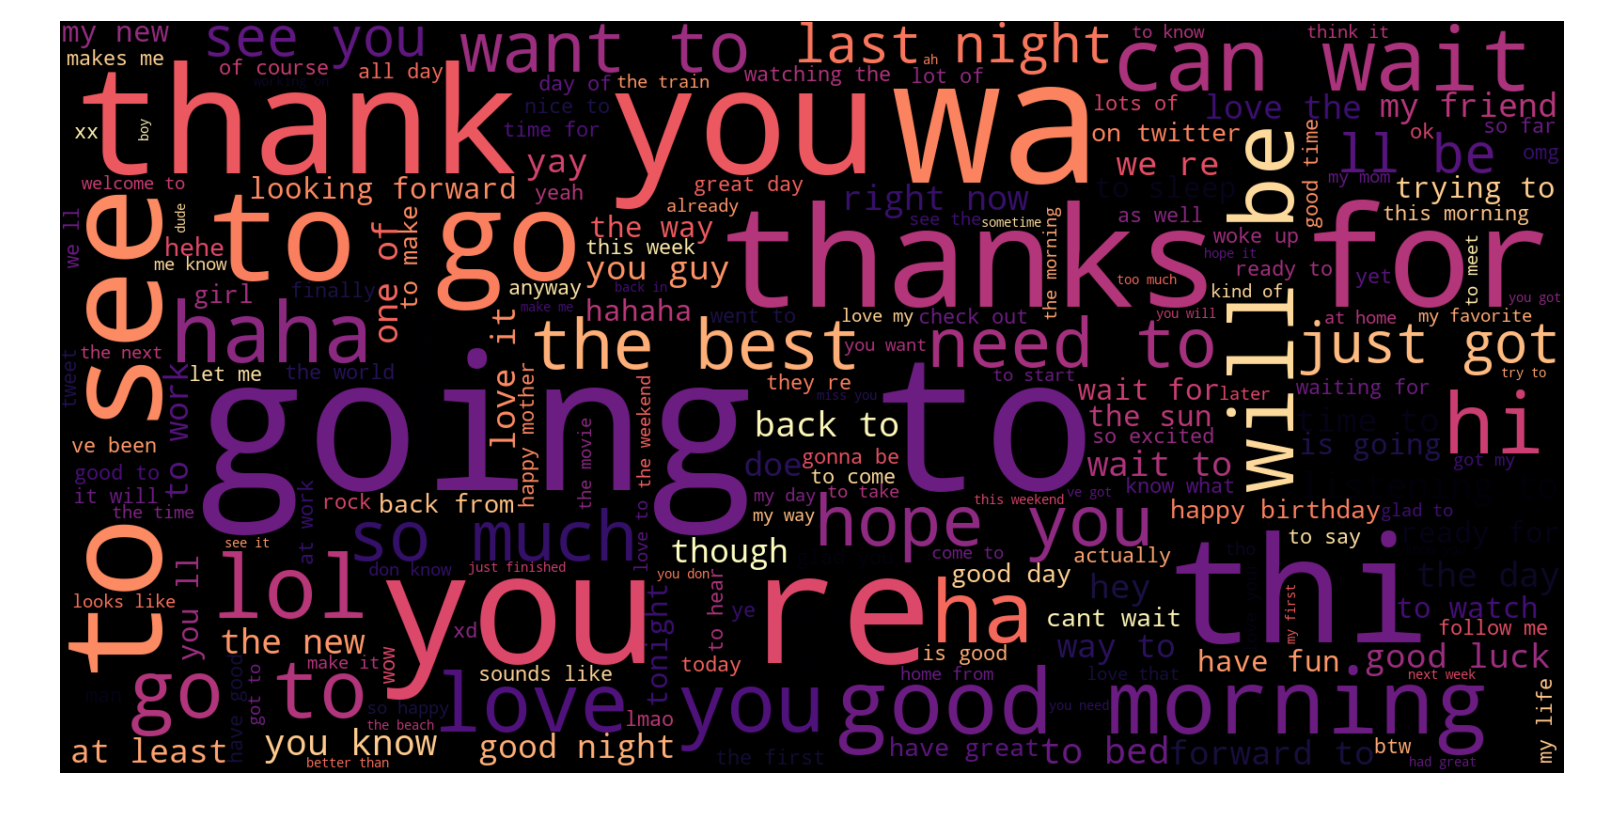

In [12]:
pos_tweets = my_df[my_df.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer()

In [14]:
len(cvec.get_feature_names())

273694

In [15]:
document_matrix = cvec.transform(my_df.text)
my_df[my_df.target == 0].tail()

,text,target
798498,sick spending my day laying in bed listening to,0
798499,gmail is down,0
798500,rest in peace farrah so sad,0
798501,urbane sounds like a rival is flagging your ad...,0
798502,has to resit exams over summer wishes he worke...,0


In [17]:
%%time
neg_batches = np.linspace(0,798179,100).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(neg_batches)-2):
        print(neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

8062 entries' term freuquency calculated
88686 entries' term freuquency calculated
169310 entries' term freuquency calculated
249934 entries' term freuquency calculated
330558 entries' term freuquency calculated
411183 entries' term freuquency calculated
491807 entries' term freuquency calculated
572431 entries' term freuquency calculated
653055 entries' term freuquency calculated
733679 entries' term freuquency calculated
798179 entries' term freuquency calculated
CPU times: user 9min 52s, sys: 9min 25s, total: 19min 18s
Wall time: 19min 54s
